<a href="https://colab.research.google.com/github/DiabeticRetinopathy114/114_DR/blob/main/VGG16_Acc~91_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
sovitrath_diabetic_retinopathy_224x224_gaussian_filtered_path = kagglehub.dataset_download('sovitrath/diabetic-retinopathy-224x224-gaussian-filtered')

print('Data source import complete.')


# **Importing Necassary Libraries**

In [ ]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import cv2
import shutil
import keras
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split

# **Mapping Classes to Data**

In [ ]:
df = pd.read_csv("../input/diabetic-retinopathy-224x224-gaussian-filtered/train.csv")

diagnosis_binary = {
        0: 'No_DR',
        1: 'DR',
        2: 'DR',
        3: 'DR',
        4: 'DR'}

diagnosis_classes = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df["binary"] = df["diagnosis"].map(diagnosis_binary.get)
df["type"] = df["diagnosis"].map(diagnosis_classes.get)

# **Data Visualization**

In [ ]:
df.head()

,id_code,diagnosis,binary,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


<AxesSubplot:>

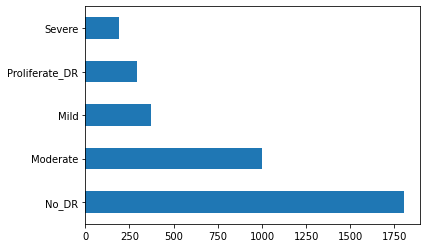

In [ ]:
df['type'].value_counts().plot(kind='barh')

<AxesSubplot:>

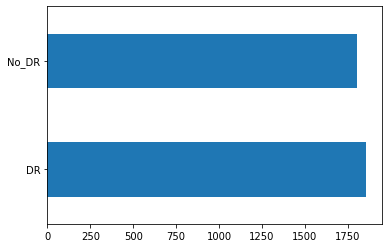

In [ ]:
df['binary'].value_counts().plot(kind='barh')

# **Data Preprocessing**

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.preprocessing import LabelBinarizer
!pip install imutils
from imutils import paths
from sklearn.utils import shuffle

>***Gathering Images and Lables***

In [ ]:
data = []
labels = []
width,height=224,224

imagePaths = list(paths.list_images('../input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images'))

data = []
labels = []

for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = load_img(imagePath, target_size=(width, height))
    image = img_to_array(image)
    data.append(image)
    labels.append(label)

data = np.array(data, dtype="float32")
labels = np.array(labels)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)

data, labels = shuffle(data, labels)

print(data.shape)
print(labels.shape)

(3662, 224, 224, 3)
(3662, 5)


>***Normalizing the Data***

In [ ]:
data = data / 255.0

# **Splitting Data to Training , Validatoin and Testing Sets**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=.2)

print("Train images:",x_train.shape)
print("Test images:",x_test.shape)
print("Train label:",y_train.shape)
print("Test label:",y_test.shape)

Train images: (2929, 224, 224, 3)
Test images: (733, 224, 224, 3)
Train label: (2929, 5)
Test label: (733, 5)


In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=.2)

print("Train images:",x_train.shape)
print("Test images:",x_val.shape)
print("Train label:",y_train.shape)
print("Test label:",y_val.shape)

Train images: (2343, 224, 224, 3)
Test images: (586, 224, 224, 3)
Train label: (2343, 5)
Test label: (586, 5)


# **Preparing VGG16 Pretrained Model**

In [ ]:
from keras.models import Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, BatchNormalization, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.applications.vgg16 import VGG16
from keras import layers

In [ ]:
Vgg16 = VGG16(include_top=False, input_shape= (224,224,3))

Vgg16.trainable=False

# **Fine-Tuning VGG16**

In [ ]:
model = Sequential()
model.add(Vgg16)
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64 , activation="relu"))
model.add(Dropout(0.25))
model.add(Dense(32 , activation="relu"))
#model.add(Dropout(0.25))
model.add(Dense(5 , activation="sigmoid"))

model.compile( optimizer="adam" , loss="binary_crossentropy" , metrics="binary_accuracy" )

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1605696   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 1

In [ ]:
# callbacks = [EarlyStopping(monitor='val_binary_accuracy' , patience=10 , restore_best_weights=True)]

history = model.fit(x_train , y_train , epochs=50 , batch_size=64,
                    validation_data=(x_val,y_val), verbose=1)
# callbacks = callbacks

Epoch 1/50
37/37 [==============================] - 6s 161ms/step - loss: 0.1969 - binary_accuracy: 0.9163 - val_loss: 0.2307 - val_binary_accuracy: 0.9078
Epoch 2/50
37/37 [==============================] - 5s 149ms/step - loss: 0.1925 - binary_accuracy: 0.9187 - val_loss: 0.2387 - val_binary_accuracy: 0.9075
Epoch 3/50
37/37 [==============================] - 6s 150ms/step - loss: 0.1973 - binary_accuracy: 0.9180 - val_loss: 0.2482 - val_binary_accuracy: 0.9065
Epoch 4/50
37/37 [==============================] - 5s 149ms/step - loss: 0.1951 - binary_accuracy: 0.9156 - val_loss: 0.2496 - val_binary_accuracy: 0.9078
Epoch 5/50
37/37 [==============================] - 6s 150ms/step - loss: 0.1902 - binary_accuracy: 0.9178 - val_loss: 0.2444 - val_binary_accuracy: 0.9102
Epoch 6/50
37/37 [==============================] - 6s 150ms/step - loss: 0.1837 - binary_accuracy: 0.9205 - val_loss: 0.2350 - val_binary_accuracy: 0.9031
Epoch 7/50
37/37 [==============================] - 6s 150ms/ste

# **Evaluating the Model Performene**

In [ ]:
def plot_curves(history):

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["binary_accuracy"]
  val_accuracy = history.history["val_binary_accuracy"]

  epochs = range(len(history.history["loss"]))

  #plot loss
  plt.plot(epochs, loss, label = "training_loss")
  plt.plot(epochs, val_loss, label = "val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  #plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label = "training_accuracy")
  plt.plot(epochs, val_accuracy, label = "val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

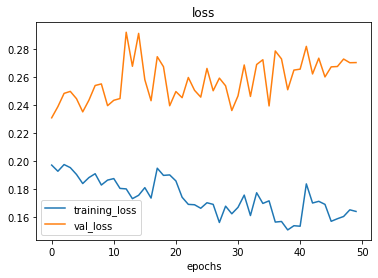

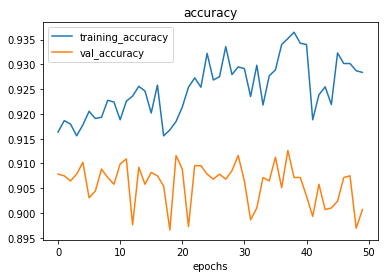

In [ ]:
plot_curves(history)

In [ ]:
score = model.evaluate(x_test,y_test)

23/23 [==============================] - 7s 185ms/step - loss: 0.2515 - binary_accuracy: 0.9050


> **Predicting Test Set**

In [ ]:
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)

# ***Visualizing a prediction***

[0 0 1 0 0]
Prediction: Moderate


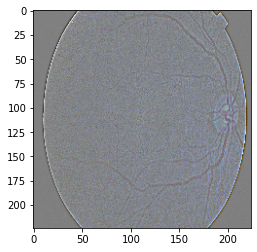

In [ ]:
index =5
predictions=["Mild","Moderate","NO_DR","Proliferate_DR","Severe"]

img = x_test[index]
RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
RGBImg= cv2.resize(RGBImg,(224,224))

plt.imshow(RGBImg)
print(y_test[index]) # true
print(f"Prediction: {predictions[pred[index]]}") # predicted

# **Predicting a new Sample**

In [ ]:
import cv2

def predict_new(path):
    img = cv2.imread(path)

    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0

    predict=model.predict(np.array([image]))
    pred=np.argmax(predict,axis=1)

    print(f"Predicted: {predictions[pred[0]]}")

Predicted: Mild


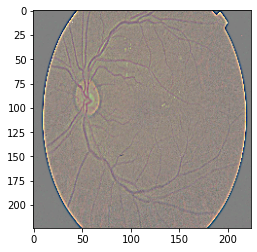

In [ ]:
predict_new("../input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Mild/01b3aed3ed4c.png")
#True --> Mild